<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

На основание исторических данных о заказах такси в аэропортах.\
Необходимо построить модель машинного обучения, способную предсказывать количество заказов на следующий час.


## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit,  train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()

Подключили необходимые библиотеки и загрузили данные. Сразу сделали ресемплирование по часу с суммированием.

## Анализ

In [2]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [3]:
df.index.is_monotonic

True

Данные отсортированы

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


У нас есть данные за шесть месяцев, с марта по август 2018 года включительно, пропусков нет, тип данных подходящий

In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Text(0.5, 1.0, 'Скользящее среднее за 24 часа')

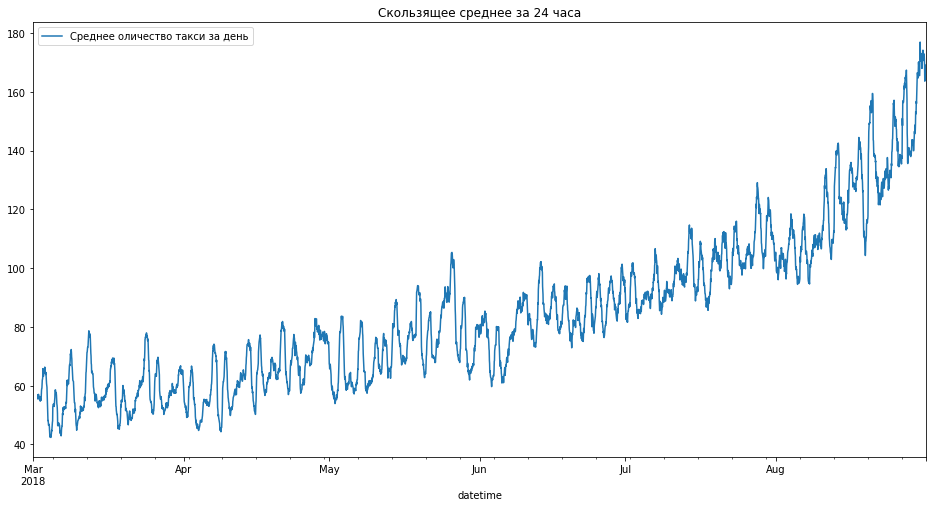

In [6]:
df['num_orders'].rolling(24).mean().plot(figsize=(16, 8))
plt.legend(['Среднее оличество такси за день'])
plt.title('Скользящее среднее за 24 часа')

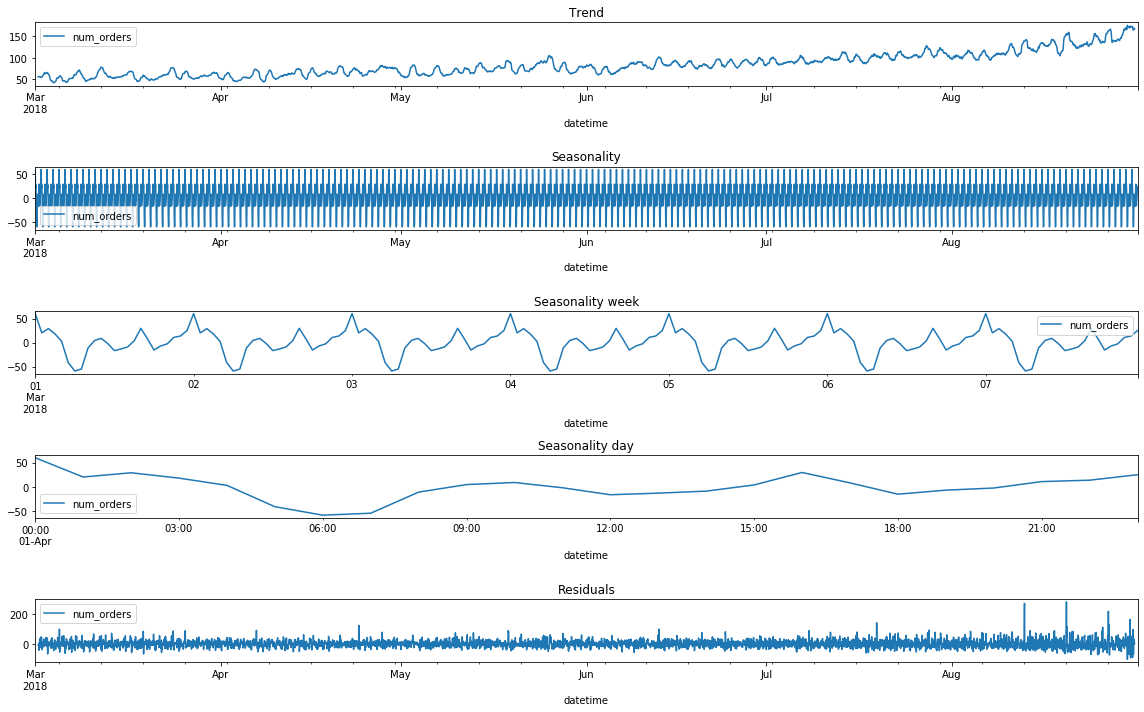

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 10))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(513)
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
plt.title('Seasonality week')
plt.subplot(514)
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-1 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality day')
plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим возрастающий тренд и ежедневную сезонность. В 6 часов утра просиходит спад заказов, вечером он плавно возрастает и в 12 часов ночи пик заказов такси.

In [8]:


test = adfuller(df['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Тест Дики-Фуллера не опровергает нулевую гипотезу, предполагающую стационарность временного ряда

## Обучение

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5,6])*1
    df['hours'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df.iloc[:,0].shift(lag)

    df['rolling_mean'] = df.iloc[:,0].shift().rolling(rolling_mean_size).mean()  

Сгенерировали фичи

In [10]:
make_features(df, 24, 12)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
num_orders      4392 non-null int64
dayofweek       4392 non-null int64
is_weekend      4392 non-null int64
hours           4392 non-null int64
lag_1           4392 non-null float64
lag_2           4392 non-null float64
lag_3           4392 non-null float64
lag_4           4392 non-null float64
lag_5           4392 non-null float64
lag_6           4392 non-null float64
lag_7           4392 non-null float64
lag_8           4392 non-null float64
lag_9           4392 non-null float64
lag_10          4392 non-null float64
lag_11          4392 non-null float64
lag_12          4392 non-null float64
lag_13          4392 non-null float64
lag_14          4392 non-null float64
lag_15          4392 non-null float64
lag_16          4392 non-null float64
lag_17          4392 non-null float64
lag_18          4392 non-null float64
lag_19          4392 

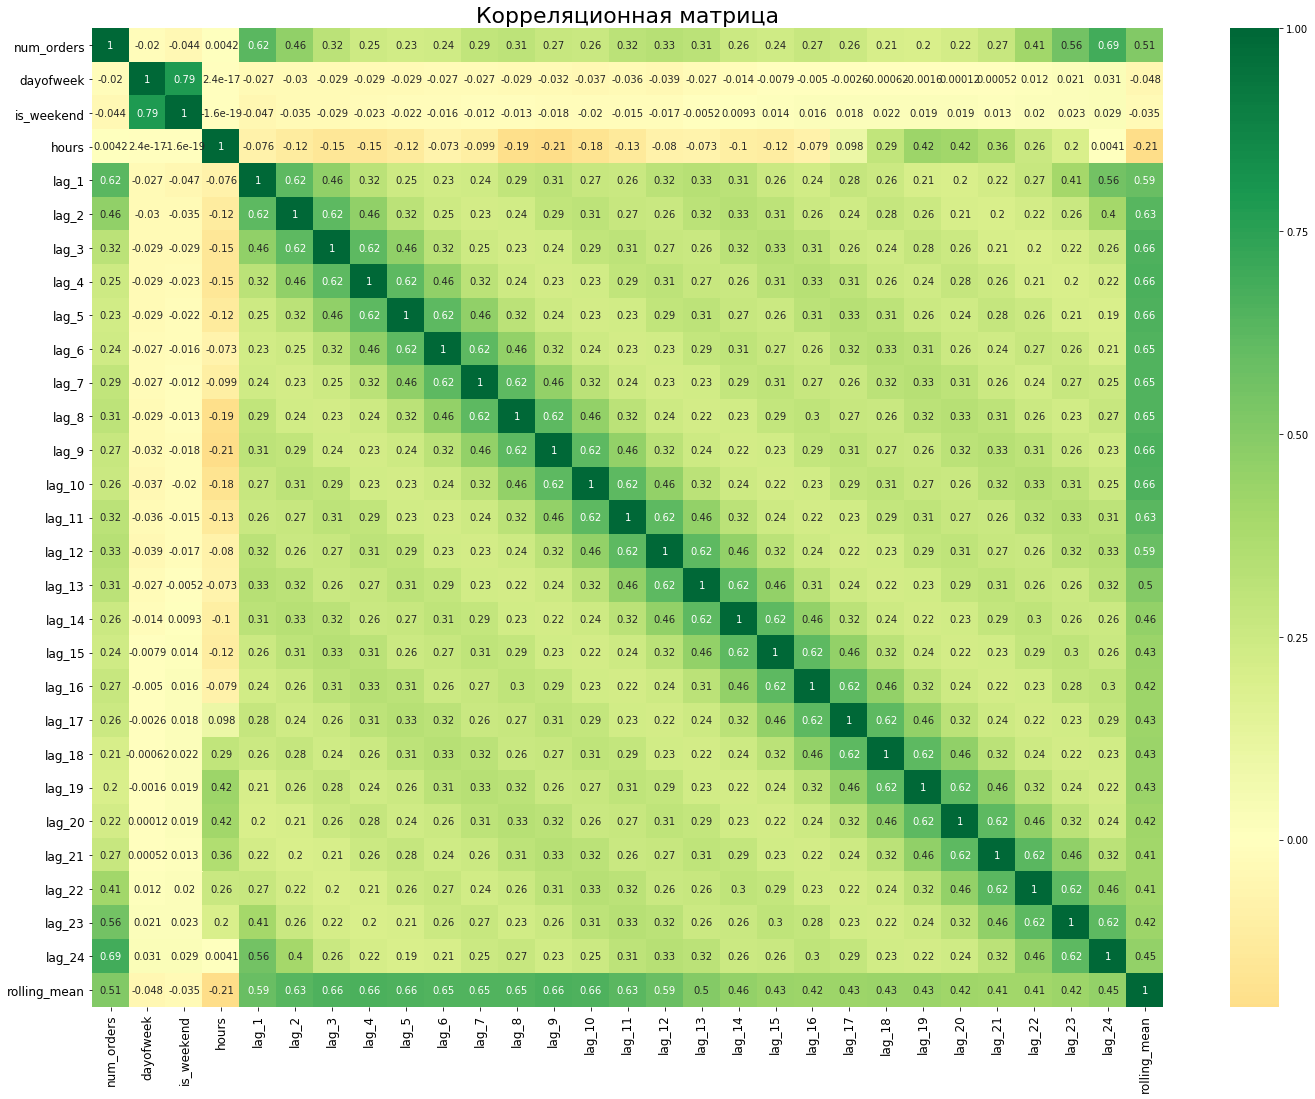

In [11]:
plt.figure(figsize=(24,18))
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)


plt.title('Корреляционная матрица', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [12]:
cat_column = ['hours', 'dayofweek', 'is_weekend'] # категориальные данные

In [13]:
train,test = train_test_split(df, test_size=0.1, shuffle=False)

In [14]:
def features_target_split(df,target):
    features = df.drop(target, axis=1)
    target = df[target]
    return features, target

In [15]:
features_test, target_test = features_target_split(test,'num_orders')
features_train, target_train = features_target_split(train,'num_orders')

Разделили выборку на тестовую и обучающую и отделили целевой признак

In [16]:
scaler = StandardScaler()
scaler.fit(features_train.iloc[:, 3:])
features_train.iloc[:, 3:] = scaler.transform(features_train.iloc[:, 3:])
features_test.iloc[:, 3:] = scaler.transform(features_test.iloc[:, 3:])

Стандартезировал данные

In [17]:
models_scors = pd.DataFrame(columns = ['model', 'rmse'])

In [18]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
pred = lr_model.predict(features_test)

models_scors = models_scors.append({'model' : 'LinearRegression',
                     'rmse' : mean_squared_error(pred, target_test) ** 0.5}, ignore_index=True)

CPU times: user 120 ms, sys: 158 ms, total: 278 ms
Wall time: 289 ms


In [19]:
%%time
LGBMR_model = LGBMRegressor(random_state=42, loss_function='RMSE', cat_features=cat_column)

parameters = [{'max_depth': [5],
               'learning_rate': [0.07],
               'n_estimators': [190]}]

LGBMR_model_gscvts = GridSearchCV(LGBMR_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True)
LGBMR_model_gscvts.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'LGBMRegressor',
                     'rmse' : abs(LGBMR_model_gscvts.best_score_) ** 0.5}, ignore_index=True)

LGBMR_model_gscvts.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.0s finished


CPU times: user 2min 58s, sys: 1.54 s, total: 2min 59s
Wall time: 3min 1s


{'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 190}

In [20]:
%%time
CBR_model = CatBoostRegressor(random_state=42, loss_function='RMSE', cat_features=cat_column, silent=True)

parameters = [{'max_depth': [6],
               'learning_rate': [0.1],
               'n_estimators': [360]}]

CBR_model_gscvts = GridSearchCV(CBR_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True, n_jobs=-1)
CBR_model_gscvts.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'CatBoostRegressor',
                     'rmse' : abs(CBR_model_gscvts.best_score_) ** 0.5}, ignore_index=True)

CBR_model_gscvts.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


CPU times: user 1min 17s, sys: 21.6 s, total: 1min 39s
Wall time: 1min 46s


{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 360}

In [21]:
%%time
dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(features_train, target_train)
pred = dummy_model.predict(features_test)

models_scors = models_scors.append({'model' : 'DummyRegressor',
                     'rmse' : mean_squared_error(pred, target_test) ** 0.5}, ignore_index=True)

CPU times: user 4.79 ms, sys: 49 µs, total: 4.84 ms
Wall time: 3.95 ms


In [22]:
models_scors

,model,rmse
0,LinearRegression,45.168189
1,LGBMRegressor,24.891486
2,CatBoostRegressor,24.003478
3,DummyRegressor,84.687683


Подобрали гиперпараметры, с незначительным отрывом победил CatBoostRegressor

## Тестирование

In [23]:
%%time
predict_test = CBR_model_gscvts.best_estimator_.predict(features_test)
print('rmse : {}'.format(mean_squared_error(predict_test, target_test) ** 0.5))

rmse : 39.72741291709955
CPU times: user 0 ns, sys: 11.5 ms, total: 11.5 ms
Wall time: 6.53 ms


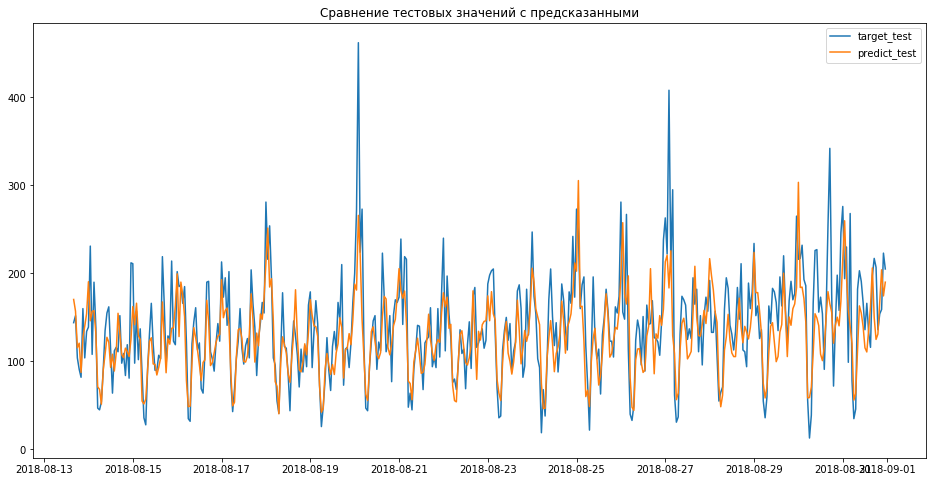

In [24]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predict_test, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()

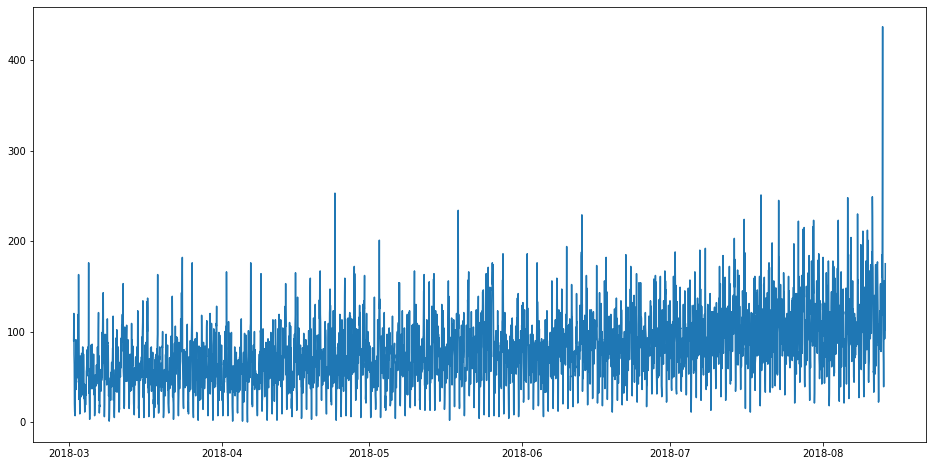

In [25]:
plt.figure(figsize=(16, 8))

plt.plot(target_train, label='target_train')

In [26]:
features_train_importance = pd.DataFrame({'name' : features_train.columns,
                                          'importance' : CBR_model_gscvts.best_estimator_.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance.head(40)

,name,importance
2,hours,17.743457
26,lag_24,17.530761
3,lag_1,8.221324
27,rolling_mean,6.871746
4,lag_2,3.847138
25,lag_23,3.241296
9,lag_7,3.169985
19,lag_17,2.854140
5,lag_3,2.785477
23,lag_21,2.475298


## Вывод

Наша модель отвечает заданным критериям. В качестве фичей задал лаг в 24 часа, хотя лаг в две недели показывает лучшие результаты. Но я решил что такая модель будет плохо обобщаться и возможна слишком сильная мультиколлинеарность. Неплохо бы было узнать место расположение аэропорта, это позволило бы задать в качестве признаков погоду и местные праздники.